## 作業五: Fruits 360 dataset (程式部分)
dataset: https://www.kaggle.com/moltean/fruits<br>
這個資料集目的是水果影像辨識。欲下載那個資料集，你必須先在Kaggle註冊一個帳號，你可以從 Wiki:https://zh.wikipedia.org/wiki/Kaggle 知道更多關於Kaggle的背景，可以藉由這次作業順便逛逛Kaggle。Github上其實作者也放了一個Fruits 360 dataset，<font color="red">並且包含程式</font>。

我們將藉由這個作業，了解如何應用Keras製作捲積類神經網路做影像辨識。(必須先裝opencv:  conda install -c anaconda opencv)下面範例分成數個步驟:
+ 首先載入資料集(注意作者的捲積類神經網路輸入為使用四通道，HSV+Gray)
+ 顯示樣本
+ 準備Training Set與Validation Set
+ 將樣本類別標籤以one-hot encoding方式編碼
+ 使用Data Augmentation技巧
+ 定義捲積類神經網路及訓練
+ 繪出Accuracy Curve
+ 評估模型準度

由於5×5 的Convolution Kernel可用兩層 3×3 的Convolution Kernel得到相同的Receptive Field。因此除了製作出作者模型外，也做另一個模型將作者的網路架構裡所有的 5×5 Kernel的Convolutional Layer，以下圖方式改為兩層 3×3 Kernel的Convolutional Layer。
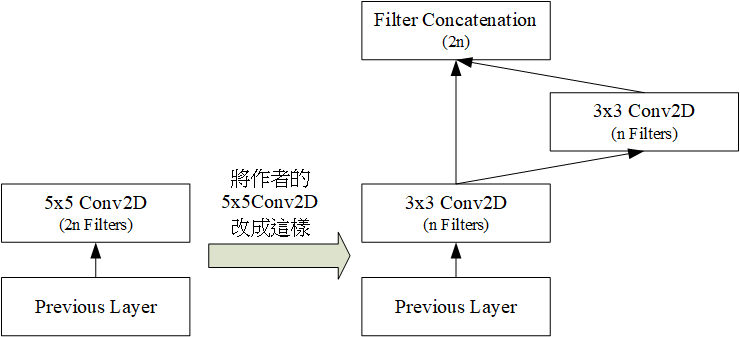

同學必須更動資料集目錄，填上下面兩個函式缺的部分，完成類神經網路架構定義
+ def define_network_architecture_5x5():
+ def define_network_architecture_3x3():

然後有耐心地跑完 (Cell執行順序先確定類神經網路架構定義是對的)

#### 載入資料集

In [ ]:
import numpy as np
import os
import glob
import cv2
import time

fruit_dir = '.\\fruits-360_dataset\\fruits-360'  #資料集目錄

class_id = {}
class_name={}
training_set_size = 0
test_set_size = 0
for idx,x in enumerate(glob.iglob(os.path.join(fruit_dir,os.path.join('Training','*')))):
    training_set_size+= len(glob.glob(os.path.join(x,'*.jpg')))
    class_id[x.split('\\')[-1]] = idx
    class_name[idx] = x.split('\\')[-1]

for idx,x in enumerate(glob.iglob(os.path.join(fruit_dir,os.path.join('Test','*')))):
    test_set_size+= len(glob.glob(os.path.join(x,'*.jpg')))

print('total number of training images: {}, total number of test images: {}, total number of classes: {}'.format(training_set_size,test_set_size,len(class_id)))

x_train = np.zeros((training_set_size,100,100,4),dtype=np.uint8)
training_label = np.zeros((training_set_size,),dtype=np.int)
x_test = np.zeros((test_set_size,100,100,4),dtype=np.uint8)
test_label = np.zeros((test_set_size,),dtype=np.int)


training_id = 0
for x in glob.iglob(os.path.join(fruit_dir,os.path.join('Training','*'))):
    cid = class_id[x.split('\\')[-1]]
    for f in glob.glob(os.path.join(x,'*.jpg')):
        img = cv2.imread(f,cv2.IMREAD_COLOR)
        g   = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        x_train[training_id,:,:,:3] =img 
        x_train[training_id,:,:,3]  =g
        training_label[training_id] = cid
        training_id = training_id + 1
        
test_id = 0        
for x in glob.iglob(os.path.join(fruit_dir,os.path.join('Test','*'))):
    cid = class_id[x.split('\\')[-1]]
    for f in glob.glob(os.path.join(x,'*.jpg')):
        img = cv2.imread(f,cv2.IMREAD_COLOR)
        g   = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        x_test[test_id,:,:,:3] = img
        x_test[test_id,:,:,3]  = g
        test_label[test_id] = cid
        test_id = test_id + 1

#### 顯示樣本

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,8))
for splt,idx in enumerate(np.random.permutation(x_train.shape[0])[:5]):
    plt.subplot(2,5,splt+1)
    img = x_train[idx,:,:,:3]
    img = cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    plt.imshow(img[:,:,::-1])
    plt.title('training:{},id#:{}'.format(class_name[training_label[idx]],idx))
    plt.axis('Off')
for splt,idx in enumerate(np.random.permutation(x_test.shape[0])[:5]):
    plt.subplot(2,5,splt+6)
    img = x_train[idx,:,:,:3]
    img = cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    plt.imshow(img[:,:,::-1])
    plt.title('test:{},id#:{}'.format(class_name[test_label[idx]],idx))
    plt.axis('Off')
plt.show()    
    

#### 準備Training Set與Validation Set

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

epochs   = 50
batchsize= 60

x_train  = x_train / 255
x_test   = x_test / 255

x_train0, x_val, train0_label, val_label = train_test_split(x_train,training_label,test_size=0.1, random_state=303)

#### 將樣本類別標籤以one-hot encoding方式編碼

In [ ]:
from keras.utils import to_categorical
y_train0  = to_categorical(train0_label)
y_val     = to_categorical(val_label)
y_test   = to_categorical(test_label)

#### 使用Data Augmentation技巧

In [ ]:
datagen = ImageDataGenerator(vertical_flip=True,horizontal_flip=True)

#### 定義捲積類神經網路

#### 定義5x5 Convolutional Layer的那個模型

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten,Dropout
from keras.optimizers import Adam

def define_network_architecture_5x5():
    model = Sequential()
    model.add(Conv2D(16,(5,5),strides=(1,1),input_shape=(100,100,4),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
#   根據作者設計加入若干層 Conv2D MaxPooling2D
#
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(103,activation='softmax'))
    model.summary()
    print('the total number of layers:{}'.format(len(model.layers)))    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
model_5x5 = define_network_architecture_5x5()

#### 開始訓練5x5那個模型

In [ ]:
s = time.time()
history_5x5 = model_5x5.fit_generator(datagen.flow(x_train0, y_train0, batch_size=batchsize),steps_per_epoch=x_train0.shape[0]//batchsize, epochs=epochs,
                   validation_data=datagen.flow(x_val, y_val))

In [ ]:
print('training time:{}'.format(time.time()-s))

#### 顯示Training History

In [ ]:
plt.figure(figsize=(8,4))
plt.title('model 5x5')
plt.plot(history_5x5.history['acc'],label='training')
plt.plot(history_5x5.history['val_acc'],label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid('On')
plt.legend()
plt.show()

#### 定義3x3 Convolutional Layer的那個模型

In [ ]:
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from keras.optimizers import Adam
def define_network_architecture_3x3():
    data = Input(shape=(100,100,4))
    x1   = Conv2D(8,(3,3),strides=(1,1),padding='same',activation='relu')(data)
    x2   = Conv2D(8,(3,3),strides=(1,1),padding='same',activation='relu')(x1)
    z    = Concatenate()([x1,x2])
    z    = MaxPooling2D(pool_size=(2,2))(z)
#   改作者設計加入若干層 Conv2D Conv2D Concatenate MaxPooling2D



#    
    z    = Flatten()(z)
    z    = Dense(1024,activation='relu')(z)
    z    = Dropout(0.8)(z)
    z    = Dense(256,activation='relu')(z)
    z    = Dropout(0.8)(z)
    z    = Dense(103,activation='softmax')(z)
    model = Model(inputs=data,outputs=z)
    model.summary()
    print('the total number of layers:{}'.format(len(model.layers)))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
model_3x3 = define_network_architecture_3x3()

#### 開始訓練3x3那個模型

In [ ]:
s = time.time()
history_3x3 = model_3x3.fit_generator(datagen.flow(x_train0, y_train0, batch_size=batchsize),steps_per_epoch=x_train0.shape[0]//batchsize, epochs=epochs,
                   validation_data=datagen.flow(x_val, y_val))

In [ ]:
print('training time:{}'.format(time.time()-s))

#### 顯示Training History

In [ ]:
plt.figure(figsize=(8,4))
plt.title('model 3x3')
plt.plot(history_3x3.history['acc'],label='training')
plt.plot(history_3x3.history['val_acc'],label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid('On')
plt.legend()
plt.show()

#### 顯示測試正確率

In [ ]:
scores_5x5 = model_5x5.evaluate(x_test,y_test)
scores_3x3 = model_3x3.evaluate(x_test,y_test)

In [ ]:
print('accuracy 5x5:{:.4f}, 3x3:{:.4f}'.format(scores_5x5[1],scores_3x3[1]))